# Phương pháp giải thuật heuristic cho bài toán thực tế #

In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
from pymoo.core.repair import Repair
from pymoo.util.ref_dirs import get_reference_directions
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# IMPORT CÁC THUẬT TOÁN MOEA
# ============================================================================
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.algorithms.moo.sms import SMSEMOA

# ============================================================================
# CẤU HÌNH
# ============================================================================
FILE_PATH = r"D:\Lợi nhuận dương.json"  # Đường dẫn file dữ liệu
POP_SIZE = 100                           # Kích thước quần thể
N_GEN = 500                              # Số thế hệ
SEED = 42                                # Seed cho tính tái lập
RISK_FREE_RATE = 0.05                    # Lãi suất phi rủi ro

## Số mờ tam giác

In [70]:
def load_data(file_path):
    """Đọc dữ liệu số mờ tam giác từ file JSON"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        triangular_fuzzy_numbers_list = []
        tickers = []
        for ticker, stock_data in data.items():
            triangular_params = stock_data['triangular']
            triangular_fuzzy_numbers_list.append([
                triangular_params['a'],
                triangular_params['b'],
                triangular_params['c']
            ])
            tickers.append(ticker)
        
        FPS = np.array(triangular_fuzzy_numbers_list)
        print(f"✅ Đã tải dữ liệu: {len(tickers)} cổ phiếu")
        return FPS, tickers
    
    except FileNotFoundError:
        print(f"⚠️ Không tìm thấy file '{file_path}'")
        print("📌 Sử dụng dữ liệu mẫu để demo...")
        return generate_sample_data()


In [71]:
# ============================================================================
# HÀM TÍNH TOÁN SỐ MỜ TAM GIÁC
# ============================================================================
def expected_tfn(fuzzy):
    """Tính kỳ vọng của số mờ tam giác"""
    return (fuzzy[0] + 4.0 * fuzzy[1] + fuzzy[2]) / 6.0

def variance_tfn(fuzzy):
    """Tính phương sai của số mờ tam giác"""
    return (np.power(fuzzy[1] - fuzzy[0], 2) + 
            np.power(fuzzy[2] - fuzzy[1], 2) + 
            (fuzzy[1] - fuzzy[0]) * (fuzzy[2] - fuzzy[1])) / 18.0

def value_at_risk_tfn(fuzzy, alpha=0.9):
    """Tính Value at Risk của số mờ tam giác"""
    if alpha <= 0.5:
        return 2 * alpha * fuzzy[1] + (1 - 2 * alpha) * fuzzy[0]
    else:
        return (2 * alpha - 1) * fuzzy[2] + (2 - 2 * alpha) * fuzzy[1]

def sharpe_ratio_tfn(fuzzy, rf=RISK_FREE_RATE):
    """Tính Sharpe Ratio của số mờ tam giác"""
    var = variance_tfn(fuzzy)
    if var <= 1e-10:
        return 0.0
    return (expected_tfn(fuzzy) - rf) / var

def var_ratio_tfn(fuzzy, rf=RISK_FREE_RATE):
    """Tính VaR Ratio của số mờ tam giác"""
    var = value_at_risk_tfn(fuzzy)
    if abs(var) <= 1e-10:
        return 0.0
    return (expected_tfn(fuzzy) - rf) / var

In [ ]:
# ============================================================================
# HÀM MỤC TIÊU CHO DANH MỤC
# ============================================================================
class PortfolioObjectives:
    """Lớp chứa các hàm mục tiêu cho danh mục đầu tư"""
    
    def __init__(self, FPS):
        self.FPS = FPS
    
    def portfolio_fuzzy(self, weights):
        """Tính số mờ tam giác của danh mục"""
        return (weights.reshape(-1, 1).T @ self.FPS).reshape(-1)
    
    def sharpe_ratio(self, weights):
        """Tính Sharpe Ratio của danh mục"""
        fuzzy = self.portfolio_fuzzy(weights)
        return sharpe_ratio_tfn(fuzzy)
    
    def var_ratio(self, weights):
        """Tính VaR Ratio của danh mục"""
        fuzzy = self.portfolio_fuzzy(weights)
        return var_ratio_tfn(fuzzy)

# ============================================================================
# ĐỊNH NGHĨA BÀI TOÁN TỐI ƯU (KHÔNG CÓ CONSTRAINTS)
# ============================================================================
class PortfolioOptimizationProblem(Problem):
    """
    Bài toán tối ưu danh mục đầu tư đa mục tiêu
    
    Mục tiêu:
    - Tối đa hóa Sharpe Ratio (SR) -> Tối thiểu hóa -SR
    - Tối đa hóa VaR Ratio (VR) -> Tối thiểu hóa -VR
    
    Ràng buộc:
    - Tổng trọng số = 1 (xử lý qua Repair, không phải constraint)
    - 0 <= w_i <= 1 (đã xử lý qua bounds)
    """
    
    def __init__(self, FPS):
        self.objectives = PortfolioObjectives(FPS)
        super().__init__(
            n_var=FPS.shape[0],    # Số biến = số cổ phiếu
            n_obj=2,               # 2 mục tiêu: SR và VR
            n_constr=0,            # KHÔNG có constraint (để tương thích MOEA/D)
            xl=0.0,                # Giới hạn dưới
            xu=1.0                 # Giới hạn trên
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        # Tính các mục tiêu (âm vì pymoo tối thiểu hóa)
        f1 = np.apply_along_axis(
            lambda xi: -self.objectives.sharpe_ratio(xi), 1, x
        )
        f2 = np.apply_along_axis(
            lambda xi: -self.objectives.var_ratio(xi), 1, x
        )
        out["F"] = np.column_stack([f1, f2])

# ============================================================================
# REPAIR - SỬA CHỮA NGHIỆM (ĐẢM BẢO TỔNG = 1)
# ============================================================================
class PortfolioRepair(Repair):
    """
    Sửa chữa nghiệm để đảm bảo:
    - Tất cả trọng số >= 0
    - Tổng trọng số = 1
    
    Đây là cách xử lý ràng buộc thay vì dùng constraint,
    giúp tương thích với tất cả thuật toán MOEA.
    """
    
    def _do(self, problem, X, **kwargs):
        X = np.clip(X, 0, None)  # Đảm bảo không âm
        
        for i in range(X.shape[0]):
            row_sum = np.sum(X[i])
            if row_sum > 0:
                X[i] /= row_sum  # Chuẩn hóa để tổng = 1
            else:
                # Nếu tất cả = 0, phân bổ đều
                X[i] = np.ones(X.shape[1]) / X.shape[1]
        
        return X

# ============================================================================
# KHỞI TẠO CÁC THUẬT TOÁN
# ============================================================================
def create_algorithms(n_obj=2, pop_size=POP_SIZE):
    """
    Tạo dictionary chứa 5 thuật toán MOEA
    
    Parameters:
    -----------
    n_obj : int
        Số mục tiêu
    pop_size : int
        Kích thước quần thể
    
    Returns:
    --------
    dict : Dictionary {tên: thuật_toán}
    """
    
    # Reference directions cho NSGA-III và MOEA/D
    ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=50)
    
    algorithms = {
        # 1. NSGA-II: Thuật toán kinh điển, sử dụng crowding distance
        "NSGA-II": NSGA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 2. NSGA-III: Sử dụng reference points, tốt cho nhiều mục tiêu
        "NSGA-III": NSGA3(
            pop_size=pop_size,
            ref_dirs=ref_dirs,
            repair=PortfolioRepair()
        ),
        
        # 3. MOEA/D: Phân rã thành các bài toán con
        #    Lưu ý: Không hỗ trợ constraints, nên dùng Repair
        "MOEA/D": MOEAD(
            ref_dirs=ref_dirs,
            n_neighbors=20,
            prob_neighbor_mating=0.9,
            repair=PortfolioRepair()
        ),
        
        # 4. AGE-MOEA-II: Ước lượng hình học thích nghi
        "AGE-MOEA-II": AGEMOEA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 5. SMS-EMOA: Sử dụng hypervolume làm tiêu chí chọn lọc
        "SMS-EMOA": SMSEMOA(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
    }
    
    return algorithms

# ============================================================================
# CHẠY VÀ SO SÁNH CÁC THUẬT TOÁN
# ============================================================================
def run_algorithm(algorithm, problem, n_gen, seed, verbose=False):
    """
    Chạy một thuật toán và trả về kết quả
    
    Returns:
    --------
    dict : Kết quả gồm res, time, hypervolume
    """
    start_time = time.time()
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', n_gen),
        seed=seed,
        save_history=True,
        verbose=verbose
    )
    
    elapsed_time = time.time() - start_time
    
    return {
        'result': res,
        'time': elapsed_time,
        'F': res.F,
        'X': res.X
    }

def calculate_hypervolume(F, margin=0.1):
    """
    Tính Hypervolume indicator
    
    Parameters:
    -----------
    F : array
        Ma trận các giá trị mục tiêu (đã âm hóa)
    margin : float
        Khoảng cách thêm vào reference point
    
    Returns:
    --------
    float : Giá trị hypervolume
    """
    # Chuyển về giá trị dương (vì đang tối đa hóa)
    F_positive = -F
    
    # Reference point: điểm xấu nhất + margin
    ref_point = [
        np.max(F_positive[:, 0]) + margin,
        np.max(F_positive[:, 1]) + margin
    ]
    
    hv = Hypervolume(ref_point=ref_point)
    return hv.do(F_positive)

def run_comparison(FPS, n_gen=N_GEN, pop_size=POP_SIZE, seed=SEED, verbose=True):
    """
    Chạy và so sánh 5 thuật toán MOEA
    
    Returns:
    --------
    dict : Kết quả của tất cả các thuật toán
    """
    problem = PortfolioOptimizationProblem(FPS)
    algorithms = create_algorithms(n_obj=2, pop_size=pop_size)
    
    results = {}
    
    print("=" * 70)
    print("BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA")
    print("=" * 70)
    print(f"📊 Số cổ phiếu: {FPS.shape[0]}")
    print(f"📊 Kích thước quần thể: {pop_size}")
    print(f"📊 Số thế hệ: {n_gen}")
    print(f"📊 Seed: {seed}")
    print("=" * 70)
    
    for name, algorithm in algorithms.items():
        print(f"\n🔄 Đang chạy {name}...")
        
        result = run_algorithm(
            algorithm, 
            problem, 
            n_gen, 
            seed, 
            verbose=False
        )
        
        # Tính hypervolume
        hv = calculate_hypervolume(result['F'])
        result['hypervolume'] = hv
        
        # Số nghiệm Pareto
        result['n_pareto'] = len(result['F'])
        
        results[name] = result
        
        print(f"   ✅ Hoàn thành trong {result['time']:.2f} giây")
        print(f"   📈 Hypervolume: {hv:.6f}")
        print(f"   🎯 Số nghiệm Pareto: {result['n_pareto']}")
    
    return results

# ============================================================================
# HIỂN THỊ KẾT QUẢ
# ============================================================================
def print_summary(results):
    """In bảng tổng hợp kết quả"""
    
    print("\n" + "=" * 70)
    print("BẢNG TỔNG HỢP KẾT QUẢ")
    print("=" * 70)
    
    # Header
    print(f"{'Thuật toán':<15} {'Hypervolume':>15} {'Số nghiệm':>12} {'Thời gian (s)':>15}")
    print("-" * 70)
    
    # Sắp xếp theo hypervolume giảm dần
    sorted_results = sorted(
        results.items(), 
        key=lambda x: x[1]['hypervolume'], 
        reverse=True
    )
    
    for i, (name, res) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else ("🥈" if i == 1 else ("🥉" if i == 2 else "  "))
        print(f"{rank} {name:<13} {res['hypervolume']:>15.6f} {res['n_pareto']:>12} {res['time']:>15.2f}")
    
    print("=" * 70)
    
    # Thuật toán tốt nhất
    best_name = sorted_results[0][0]
    print(f"\n🏆 Thuật toán tốt nhất (theo Hypervolume): {best_name}")

def plot_pareto_fronts(results, save_path=None):
    """
    Vẽ Pareto fronts của tất cả các thuật toán
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # Plot từng thuật toán riêng
    for idx, (name, res) in enumerate(results.items()):
        ax = axes[idx]
        F = -res['F']  # Chuyển về giá trị dương
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
        ax.set_xlabel('Sharpe Ratio', fontsize=10)
        ax.set_ylabel('VaR Ratio', fontsize=10)
        ax.set_title(f'{name}\nHV={res["hypervolume"]:.4f}, N={res["n_pareto"]}', fontsize=11)
        ax.grid(True, alpha=0.3)
    
    # Plot tất cả trên cùng một đồ thị
    ax = axes[5]
    for idx, (name, res) in enumerate(results.items()):
        F = -res['F']
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.6, s=20, label=name, edgecolors='black', linewidth=0.3)
    ax.set_xlabel('Sharpe Ratio', fontsize=10)
    ax.set_ylabel('VaR Ratio', fontsize=10)
    ax.set_title('So sánh tất cả Pareto Fronts', fontsize=11)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('So sánh Pareto Fronts của 5 thuật toán MOEA\nBài toán tối ưu danh mục đầu tư', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_convergence(results, save_path=None):
    """
    Vẽ đồ thị hội tụ (hypervolume theo thế hệ)
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for idx, (name, res) in enumerate(results.items()):
        history = res['result'].history
        
        if history is not None:
            hvs = []
            generations = []
            
            for gen, algo in enumerate(history):
                if algo.opt is not None and len(algo.opt) > 0:
                    F = algo.opt.get("F")
                    if F is not None and len(F) > 0:
                        try:
                            hv = calculate_hypervolume(F)
                            hvs.append(hv)
                            generations.append(gen)
                        except:
                            pass
            
            if hvs:
                ax.plot(generations, hvs, c=colors[idx], label=name, linewidth=2)
    
    ax.set_xlabel('Thế hệ', fontsize=12)
    ax.set_ylabel('Hypervolume', fontsize=12)
    ax.set_title('Đồ thị hội tụ - Hypervolume theo thế hệ', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_time_comparison(results, save_path=None):
    """
    Vẽ biểu đồ so sánh thời gian chạy
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    names = list(results.keys())
    times = [results[name]['time'] for name in names]
    hvs = [results[name]['hypervolume'] for name in names]
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    bars = ax.bar(names, times, color=colors, alpha=0.7, edgecolor='black')
    
    # Thêm giá trị hypervolume lên mỗi cột
    for bar, hv in zip(bars, hvs):
        height = bar.get_height()
        ax.annotate(f'HV={hv:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Thuật toán', fontsize=12)
    ax.set_ylabel('Thời gian (giây)', fontsize=12)
    ax.set_title('So sánh thời gian chạy của 5 thuật toán MOEA', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def get_best_portfolio(results, tickers=None):
    """
    Lấy danh mục tốt nhất từ mỗi thuật toán
    (Nghiệm có Sharpe Ratio cao nhất)
    """
    print("\n" + "=" * 70)
    print("DANH MỤC TỐT NHẤT (SHARPE RATIO CAO NHẤT) TỪ MỖI THUẬT TOÁN")
    print("=" * 70)
    
    for name, res in results.items():
        F = -res['F']  # Chuyển về giá trị dương
        X = res['X']
        
        # Tìm nghiệm có Sharpe Ratio cao nhất
        best_idx = np.argmax(F[:, 0])
        best_weights = X[best_idx]
        best_sr = F[best_idx, 0]
        best_vr = F[best_idx, 1]
        
        print(f"\n📌 {name}:")
        print(f"   Sharpe Ratio: {best_sr:.6f}")
        print(f"   VaR Ratio: {best_vr:.6f}")
        
        # In các cổ phiếu có trọng số > 1%
        significant = np.where(best_weights > 0.01)[0]
        print(f"   Số cổ phiếu trong danh mục (>1%): {len(significant)}")
        
        if tickers is not None and len(significant) <= 10:
            print("   Phân bổ:")
            for idx in np.argsort(-best_weights[significant]):
                stock_idx = significant[idx]
                print(f"      - {tickers[stock_idx]}: {best_weights[stock_idx]*100:.2f}%")

# ============================================================================
# HÀM CHÍNH
# ============================================================================
def main():
    """Hàm chính để chạy so sánh"""
    
    print("🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA")
    print("   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu")
    print("   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio")
    print()
    
    # Đọc dữ liệu
    FPS, tickers = load_data(FILE_PATH)
    
    # Chạy so sánh
    results = run_comparison(
        FPS, 
        n_gen=N_GEN, 
        pop_size=POP_SIZE, 
        seed=SEED
    )
    
    # In tổng hợp
    print_summary(results)
    
    # Danh mục tốt nhất
    get_best_portfolio(results, tickers)
    
    # Vẽ đồ thị
    print("\n📊 Đang vẽ đồ thị...")
    plot_pareto_fronts(results, save_path='pareto_fronts.png')
    plot_convergence(results, save_path='convergence.png')
    plot_time_comparison(results, save_path='time_comparison.png')
    
    print("\n✅ HOÀN THÀNH!")
    
    return results

# ============================================================================
# CHẠY CHƯƠNG TRÌNH
# ============================================================================
if __name__ == "__main__":
    results = main()


🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA
   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu
   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio

✅ Đã tải dữ liệu: 60 cổ phiếu
BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA
📊 Số cổ phiếu: 60
📊 Kích thước quần thể: 100
📊 Số thế hệ: 500
📊 Seed: 42

🔄 Đang chạy NSGA-II...
   ✅ Hoàn thành trong 54.58 giây
   📈 Hypervolume: 0.013030
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy NSGA-III...
   ✅ Hoàn thành trong 51.02 giây
   📈 Hypervolume: 0.011773
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy MOEA/D...
   ✅ Hoàn thành trong 26.58 giây
   📈 Hypervolume: 0.011828
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy AGE-MOEA-II...
   ✅ Hoàn thành trong 33.62 giây
   📈 Hypervolume: 0.012214
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy SMS-EMOA...


## Hình thang

In [ ]:
def load_data(file_path):
    """Đọc dữ liệu số mờ hình thang (trapezoidal fuzzy numbers) từ file JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    trapezoidal_fuzzy_numbers_list = []
    tickers = []

    for ticker, stock_data in data.items():
        trap_params = stock_data['trapezoidal']
        trapezoidal_fuzzy_numbers_list.append([
            trap_params['a'],
            trap_params['b'],
            trap_params['c'],
            trap_params['d']
        ])
        tickers.append(ticker)

    TFPS = np.array(trapezoidal_fuzzy_numbers_list)
    print(f"✅ Đã tải dữ liệu: {len(tickers)} cổ phiếu (TRFN)")

    return TFPS, tickers

In [ ]:
def expected_trfn(fuzzy):
    return (fuzzy[0] + 2. * fuzzy[1] + 2. * fuzzy[2] + fuzzy[3]) / 6.

def variance_trfn(fuzzy):
    return (np.power(fuzzy[1] + fuzzy[3] - fuzzy[0] - fuzzy[2], 2) + 6. * np.power(fuzzy[1] - fuzzy[2], 2) - 4. * (fuzzy[1] - fuzzy[2]) * (fuzzy[1] + fuzzy[3] - fuzzy[0] - fuzzy[2])) / 24

def value_at_risk_trfn(fuzzy):
    alpha = 0.9
    if alpha <= 0.5:
        return 2 * alpha * fuzzy[1] + (1 - 2 * alpha) * fuzzy[0]
    else:
        return (2 * alpha - 1) * fuzzy[3] + (2 - 2 * alpha) * fuzzy[2]
    
def VR_trfn(fuzzy):
    return (expected_trfn(fuzzy) - 0.05) / value_at_risk_trfn(fuzzy)

def SR_trfn(fuzzy):
    return (expected_trfn(fuzzy) - 0.05) / variance_trfn(fuzzy)

def SR(X):
    return SR_trfn((X.reshape(-1, 1).T @ TFPS).reshape(-1))

def VR(X):
    return VR_trfn((X.reshape(-1, 1).T @ TFPS).reshape(-1))

🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA
   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu
   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio

✅ Đã tải dữ liệu: 60 cổ phiếu (TRFN)
BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA
📊 Số cổ phiếu: 60
📊 Kích thước quần thể: 100
📊 Số thế hệ: 500
📊 Seed: 42

🔄 Đang chạy NSGA-II...
   ✅ Hoàn thành trong 18.00 giây
   📈 Hypervolume: 0.011288
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy NSGA-III...
   ✅ Hoàn thành trong 18.54 giây
   📈 Hypervolume: 0.010924
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy MOEA/D...
   ✅ Hoàn thành trong 24.97 giây
   📈 Hypervolume: 0.010570
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy AGE-MOEA-II...
   ✅ Hoàn thành trong 32.42 giây
   📈 Hypervolume: 0.011286
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy SMS-EMOA...
   ✅ Hoàn thành trong 35.46 giây
   📈 Hypervolume: 0.011032
   🎯 Số nghiệm Pareto: 100

BẢNG TỔNG HỢP KẾT QUẢ
Thuật toán          Hypervolume    Số nghiệm   Thời gian (s)
----------------------------------------------------------------------
🥇 N

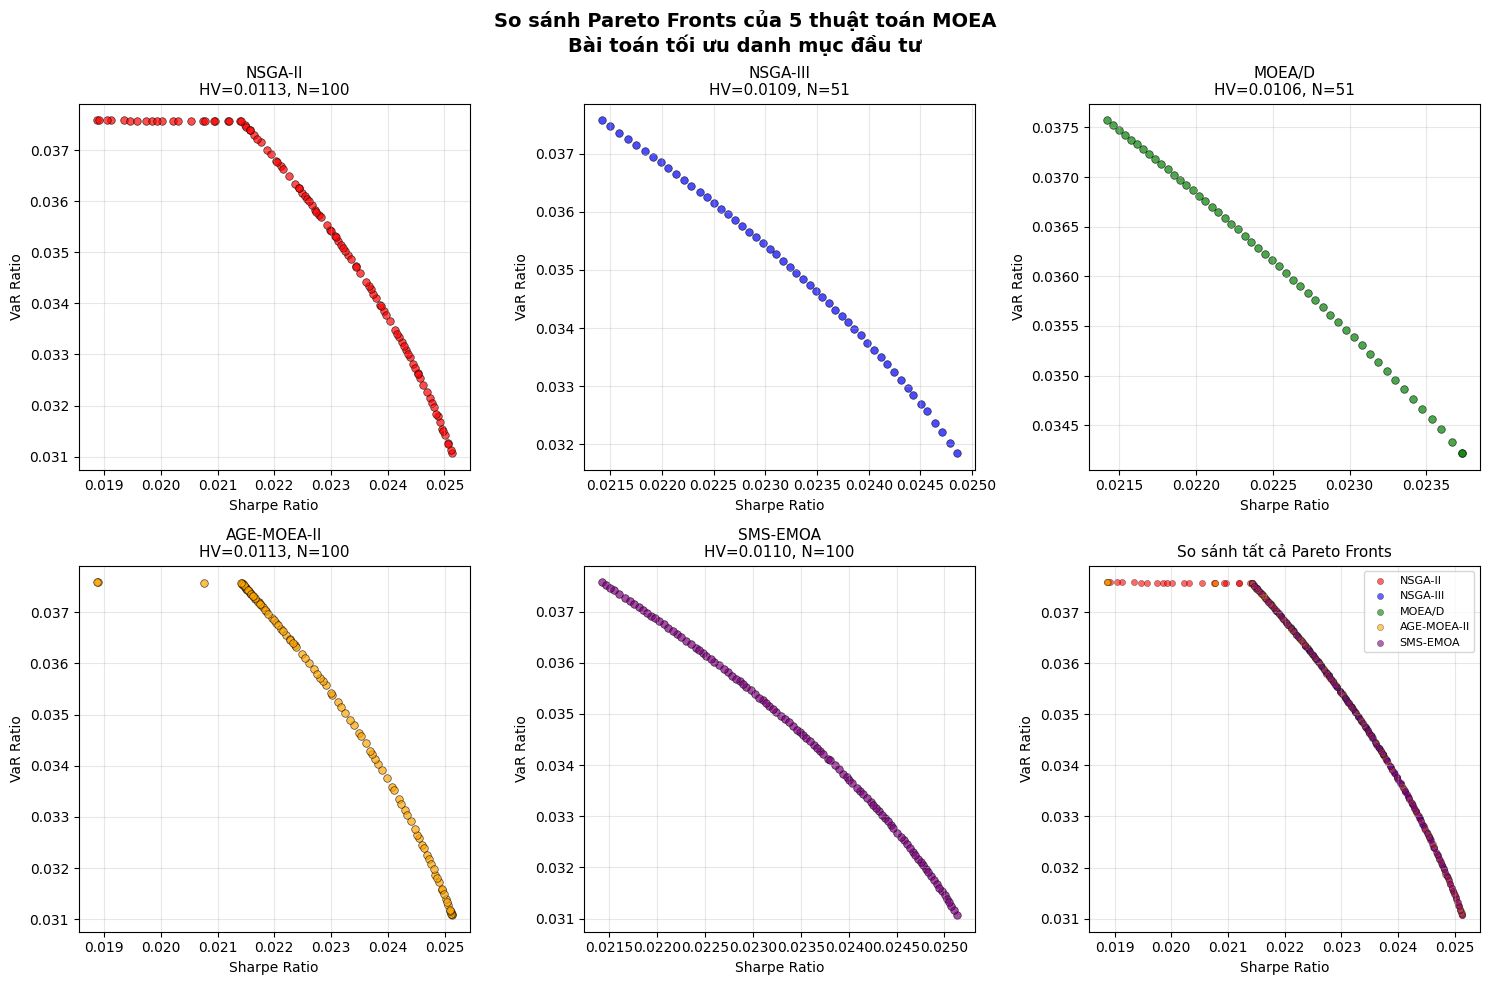

💾 Đã lưu hình: convergence.png


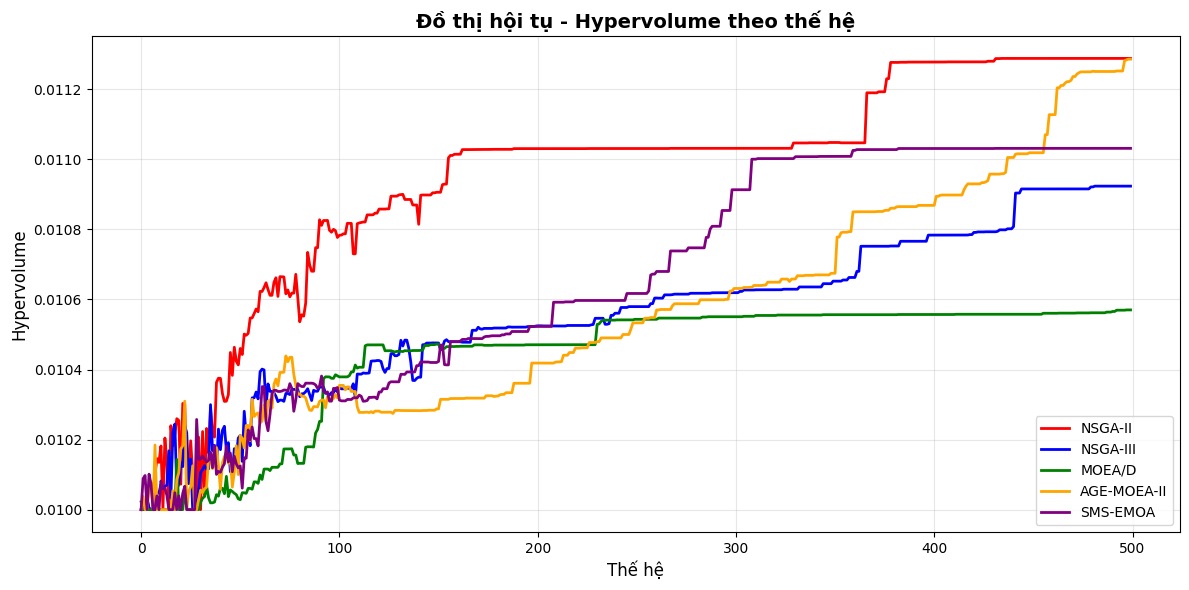

💾 Đã lưu hình: time_comparison.png


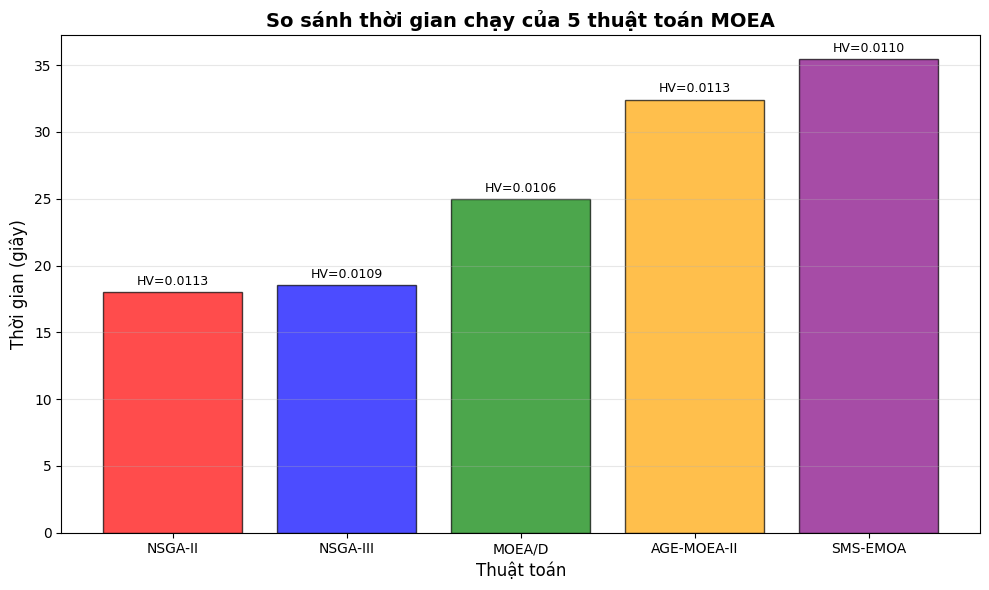


✅ HOÀN THÀNH!


In [68]:
# ============================================================================
# HÀM MỤC TIÊU CHO DANH MỤC (PHÙ HỢP TRFN)
# ============================================================================
class PortfolioObjectives:
    """Lớp chứa các hàm mục tiêu cho danh mục đầu tư với số mờ hình thang"""

    def __init__(self, TFPS):
        self.TFPS = TFPS   # Trapezoidal Fuzzy Portfolio Set

    def portfolio_fuzzy(self, weights):
        """
        Tính số mờ hình thang (a,b,c,d) của danh mục
        """
        return (weights.reshape(-1, 1).T @ self.TFPS).reshape(-1)

    def sharpe_ratio(self, weights):
        """
        Sharpe Ratio cho TRFN
        """
        fuzzy = self.portfolio_fuzzy(weights)
        return SR_trfn(fuzzy)     # ✅ ĐÚNG HÀM TRFN

    def var_ratio(self, weights):
        """
        VaR Ratio cho TRFN
        """
        fuzzy = self.portfolio_fuzzy(weights)
        return VR_trfn(fuzzy)     # ✅ ĐÚNG HÀM TRFN


# ============================================================================
# ĐỊNH NGHĨA BÀI TOÁN TỐI ƯU (KHÔNG CONSTRAINT – DÙNG REPAIR)
# ============================================================================
class PortfolioOptimizationProblem(Problem):
    """
    Tối ưu đa mục tiêu danh mục đầu tư với số mờ hình thang

    Mục tiêu:
    - max Sharpe Ratio
    - max VaR Ratio
    """

    def __init__(self, TFPS):
        self.objectives = PortfolioObjectives(TFPS)

        super().__init__(
            n_var=TFPS.shape[0],   # số cổ phiếu
            n_obj=2,
            n_constr=0,
            xl=0.0,
            xu=1.0
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # pymoo MINIMIZE → lấy dấu âm
        f1 = np.apply_along_axis(
            lambda x: -self.objectives.sharpe_ratio(x), 1, X
        )
        f2 = np.apply_along_axis(
            lambda x: -self.objectives.var_ratio(x), 1, X
        )

        out["F"] = np.column_stack([f1, f2])


# ============================================================================
# REPAIR - SỬA CHỮA NGHIỆM (ĐẢM BẢO TỔNG = 1)
# ============================================================================
class PortfolioRepair(Repair):
    """
    Sửa chữa nghiệm để đảm bảo:
    - Tất cả trọng số >= 0
    - Tổng trọng số = 1
    
    Đây là cách xử lý ràng buộc thay vì dùng constraint,
    giúp tương thích với tất cả thuật toán MOEA.
    """
    
    def _do(self, problem, X, **kwargs):
        X = np.clip(X, 0, None)  # Đảm bảo không âm
        
        for i in range(X.shape[0]):
            row_sum = np.sum(X[i])
            if row_sum > 0:
                X[i] /= row_sum  # Chuẩn hóa để tổng = 1
            else:
                # Nếu tất cả = 0, phân bổ đều
                X[i] = np.ones(X.shape[1]) / X.shape[1]
        
        return X

# ============================================================================
# KHỞI TẠO CÁC THUẬT TOÁN
# ============================================================================
def create_algorithms(n_obj=2, pop_size=POP_SIZE):
    """
    Tạo dictionary chứa 5 thuật toán MOEA
    
    Parameters:
    -----------
    n_obj : int
        Số mục tiêu
    pop_size : int
        Kích thước quần thể
    
    Returns:
    --------
    dict : Dictionary {tên: thuật_toán}
    """
    
    # Reference directions cho NSGA-III và MOEA/D
    ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=50)
    
    algorithms = {
        # 1. NSGA-II: Thuật toán kinh điển, sử dụng crowding distance
        "NSGA-II": NSGA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 2. NSGA-III: Sử dụng reference points, tốt cho nhiều mục tiêu
        "NSGA-III": NSGA3(
            pop_size=pop_size,
            ref_dirs=ref_dirs,
            repair=PortfolioRepair()
        ),
        
        # 3. MOEA/D: Phân rã thành các bài toán con
        #    Lưu ý: Không hỗ trợ constraints, nên dùng Repair
        "MOEA/D": MOEAD(
            ref_dirs=ref_dirs,
            n_neighbors=20,
            prob_neighbor_mating=0.9,
            repair=PortfolioRepair()
        ),
        
        # 4. AGE-MOEA-II: Ước lượng hình học thích nghi
        "AGE-MOEA-II": AGEMOEA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 5. SMS-EMOA: Sử dụng hypervolume làm tiêu chí chọn lọc
        "SMS-EMOA": SMSEMOA(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
    }
    
    return algorithms

# ============================================================================
# CHẠY VÀ SO SÁNH CÁC THUẬT TOÁN
# ============================================================================
def run_algorithm(algorithm, problem, n_gen, seed, verbose=False):
    """
    Chạy một thuật toán và trả về kết quả
    
    Returns:
    --------
    dict : Kết quả gồm res, time, hypervolume
    """
    start_time = time.time()
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', n_gen),
        seed=seed,
        save_history=True,
        verbose=verbose
    )
    
    elapsed_time = time.time() - start_time
    
    return {
        'result': res,
        'time': elapsed_time,
        'F': res.F,
        'X': res.X
    }

def calculate_hypervolume(F, margin=0.1):
    """
    Tính Hypervolume indicator
    
    Parameters:
    -----------
    F : array
        Ma trận các giá trị mục tiêu (đã âm hóa)
    margin : float
        Khoảng cách thêm vào reference point
    
    Returns:
    --------
    float : Giá trị hypervolume
    """
    # Chuyển về giá trị dương (vì đang tối đa hóa)
    F_positive = -F
    
    # Reference point: điểm xấu nhất + margin
    ref_point = [
        np.max(F_positive[:, 0]) + margin,
        np.max(F_positive[:, 1]) + margin
    ]
    
    hv = Hypervolume(ref_point=ref_point)
    return hv.do(F_positive)

def run_comparison(FPS, n_gen=N_GEN, pop_size=POP_SIZE, seed=SEED, verbose=True):
    """
    Chạy và so sánh 5 thuật toán MOEA
    
    Returns:
    --------
    dict : Kết quả của tất cả các thuật toán
    """
    problem = PortfolioOptimizationProblem(FPS)
    algorithms = create_algorithms(n_obj=2, pop_size=pop_size)
    
    results = {}
    
    print("=" * 70)
    print("BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA")
    print("=" * 70)
    print(f"📊 Số cổ phiếu: {FPS.shape[0]}")
    print(f"📊 Kích thước quần thể: {pop_size}")
    print(f"📊 Số thế hệ: {n_gen}")
    print(f"📊 Seed: {seed}")
    print("=" * 70)
    
    for name, algorithm in algorithms.items():
        print(f"\n🔄 Đang chạy {name}...")
        
        result = run_algorithm(
            algorithm, 
            problem, 
            n_gen, 
            seed, 
            verbose=False
        )
        
        # Tính hypervolume
        hv = calculate_hypervolume(result['F'])
        result['hypervolume'] = hv
        
        # Số nghiệm Pareto
        result['n_pareto'] = len(result['F'])
        
        results[name] = result
        
        print(f"   ✅ Hoàn thành trong {result['time']:.2f} giây")
        print(f"   📈 Hypervolume: {hv:.6f}")
        print(f"   🎯 Số nghiệm Pareto: {result['n_pareto']}")
    
    return results

# ============================================================================
# HIỂN THỊ KẾT QUẢ
# ============================================================================
def print_summary(results):
    """In bảng tổng hợp kết quả"""
    
    print("\n" + "=" * 70)
    print("BẢNG TỔNG HỢP KẾT QUẢ")
    print("=" * 70)
    
    # Header
    print(f"{'Thuật toán':<15} {'Hypervolume':>15} {'Số nghiệm':>12} {'Thời gian (s)':>15}")
    print("-" * 70)
    
    # Sắp xếp theo hypervolume giảm dần
    sorted_results = sorted(
        results.items(), 
        key=lambda x: x[1]['hypervolume'], 
        reverse=True
    )
    
    for i, (name, res) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else ("🥈" if i == 1 else ("🥉" if i == 2 else "  "))
        print(f"{rank} {name:<13} {res['hypervolume']:>15.6f} {res['n_pareto']:>12} {res['time']:>15.2f}")
    
    print("=" * 70)
    
    # Thuật toán tốt nhất
    best_name = sorted_results[0][0]
    print(f"\n🏆 Thuật toán tốt nhất (theo Hypervolume): {best_name}")

def plot_pareto_fronts(results, save_path=None):
    """
    Vẽ Pareto fronts của tất cả các thuật toán
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # Plot từng thuật toán riêng
    for idx, (name, res) in enumerate(results.items()):
        ax = axes[idx]
        F = -res['F']  # Chuyển về giá trị dương
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
        ax.set_xlabel('Sharpe Ratio', fontsize=10)
        ax.set_ylabel('VaR Ratio', fontsize=10)
        ax.set_title(f'{name}\nHV={res["hypervolume"]:.4f}, N={res["n_pareto"]}', fontsize=11)
        ax.grid(True, alpha=0.3)
    
    # Plot tất cả trên cùng một đồ thị
    ax = axes[5]
    for idx, (name, res) in enumerate(results.items()):
        F = -res['F']
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.6, s=20, label=name, edgecolors='black', linewidth=0.3)
    ax.set_xlabel('Sharpe Ratio', fontsize=10)
    ax.set_ylabel('VaR Ratio', fontsize=10)
    ax.set_title('So sánh tất cả Pareto Fronts', fontsize=11)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('So sánh Pareto Fronts của 5 thuật toán MOEA\nBài toán tối ưu danh mục đầu tư', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_convergence(results, save_path=None):
    """
    Vẽ đồ thị hội tụ (hypervolume theo thế hệ)
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for idx, (name, res) in enumerate(results.items()):
        history = res['result'].history
        
        if history is not None:
            hvs = []
            generations = []
            
            for gen, algo in enumerate(history):
                if algo.opt is not None and len(algo.opt) > 0:
                    F = algo.opt.get("F")
                    if F is not None and len(F) > 0:
                        try:
                            hv = calculate_hypervolume(F)
                            hvs.append(hv)
                            generations.append(gen)
                        except:
                            pass
            
            if hvs:
                ax.plot(generations, hvs, c=colors[idx], label=name, linewidth=2)
    
    ax.set_xlabel('Thế hệ', fontsize=12)
    ax.set_ylabel('Hypervolume', fontsize=12)
    ax.set_title('Đồ thị hội tụ - Hypervolume theo thế hệ', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_time_comparison(results, save_path=None):
    """
    Vẽ biểu đồ so sánh thời gian chạy
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    names = list(results.keys())
    times = [results[name]['time'] for name in names]
    hvs = [results[name]['hypervolume'] for name in names]
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    bars = ax.bar(names, times, color=colors, alpha=0.7, edgecolor='black')
    
    # Thêm giá trị hypervolume lên mỗi cột
    for bar, hv in zip(bars, hvs):
        height = bar.get_height()
        ax.annotate(f'HV={hv:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Thuật toán', fontsize=12)
    ax.set_ylabel('Thời gian (giây)', fontsize=12)
    ax.set_title('So sánh thời gian chạy của 5 thuật toán MOEA', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def get_best_portfolio(results, tickers=None):
    """
    Lấy danh mục tốt nhất từ mỗi thuật toán
    (Nghiệm có Sharpe Ratio cao nhất)
    """
    print("\n" + "=" * 70)
    print("DANH MỤC TỐT NHẤT (SHARPE RATIO CAO NHẤT) TỪ MỖI THUẬT TOÁN")
    print("=" * 70)
    
    for name, res in results.items():
        F = -res['F']  # Chuyển về giá trị dương
        X = res['X']
        
        # Tìm nghiệm có Sharpe Ratio cao nhất
        best_idx = np.argmax(F[:, 0])
        best_weights = X[best_idx]
        best_sr = F[best_idx, 0]
        best_vr = F[best_idx, 1]
        
        print(f"\n📌 {name}:")
        print(f"   Sharpe Ratio: {best_sr:.6f}")
        print(f"   VaR Ratio: {best_vr:.6f}")
        
        # In các cổ phiếu có trọng số > 1%
        significant = np.where(best_weights > 0.01)[0]
        print(f"   Số cổ phiếu trong danh mục (>1%): {len(significant)}")
        
        if tickers is not None and len(significant) <= 10:
            print("   Phân bổ:")
            for idx in np.argsort(-best_weights[significant]):
                stock_idx = significant[idx]
                print(f"      - {tickers[stock_idx]}: {best_weights[stock_idx]*100:.2f}%")

# ============================================================================
# HÀM CHÍNH
# ============================================================================
def main():
    """Hàm chính để chạy so sánh"""
    
    print("🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA")
    print("   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu")
    print("   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio")
    print()
    
    # Đọc dữ liệu
    TFPS, tickers = load_data(FILE_PATH)
    
    # Chạy so sánh
    results = run_comparison(
        TFPS, 
        n_gen=N_GEN, 
        pop_size=POP_SIZE, 
        seed=SEED
    )
    
    # In tổng hợp
    print_summary(results)
    
    # Danh mục tốt nhất
    get_best_portfolio(results, tickers)
    
    # Vẽ đồ thị
    print("\n📊 Đang vẽ đồ thị...")
    plot_pareto_fronts(results, save_path='pareto_fronts.png')
    plot_convergence(results, save_path='convergence.png')
    plot_time_comparison(results, save_path='time_comparison.png')
    
    print("\n✅ HOÀN THÀNH!")
    
    return results

# ============================================================================
# CHẠY CHƯƠNG TRÌNH
# ============================================================================
if __name__ == "__main__":
    results = main()


## Hàm Gaussian

In [ ]:
def load_data_gaussian(file_path):
    """Đọc dữ liệu số mờ Gaussian từ file JSON"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    gaussian_fuzzy_numbers_list = []
    tickers = []

    for ticker, stock_data in data.items():
        gauss_params = stock_data['gaussian']
        gaussian_fuzzy_numbers_list.append([
            gauss_params['center'],
            gauss_params['sigma']
        ])
        tickers.append(ticker)

    GFPS = np.array(gaussian_fuzzy_numbers_list)
    print(f"✅ Đã tải dữ liệu: {len(tickers)} cổ phiếu (Gaussian)")

    return GFPS, tickers


In [ ]:

def expected_efn(fuzzy):
    return (np.sqrt(6) * fuzzy * np.log(2)) / np.pi

def variance_efn(fuzzy):
    return 2.0031 * np.power(fuzzy, 2)

def value_at_risk_efn(fuzzy):
    alpha = 0.9
    return np.max([(np.log(alpha) - np.log(1 - alpha)) * np.sqrt(6) * fuzzy / np.pi, np.zeros_like(fuzzy)], axis=0)
    
def VR_efn(fuzzy):
    return (expected_efn(fuzzy) - 0.05) / value_at_risk_efn(fuzzy).reshape(-1)

def SR_efn(fuzzy):
    return (expected_efn(fuzzy) - 0.05) / variance_efn(fuzzy)

def SR(X):
    return SR_efn(X.reshape(-1, 1).T @ EFPS).reshape(-1)

def VR(X):
    return VR_efn(X.reshape(-1, 1).T @ EFPS).reshape(-1)

🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA
   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu
   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio

✅ Đã tải dữ liệu: 60 cổ phiếu (Gaussian)
BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA
📊 Số cổ phiếu: 60
📊 Kích thước quần thể: 100
📊 Số thế hệ: 500

🔄 Đang chạy NSGA-II...
   ✅ Hoàn thành trong 15.06 giây
   📈 Hypervolume: 0.1547235310
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy NSGA-III...
   ✅ Hoàn thành trong 18.75 giây
   📈 Hypervolume: 0.1546354937
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy MOEA/D...
   ✅ Hoàn thành trong 23.99 giây
   📈 Hypervolume: 0.1487504963
   🎯 Số nghiệm Pareto: 51

🔄 Đang chạy AGE-MOEA-II...
   ✅ Hoàn thành trong 55.17 giây
   📈 Hypervolume: 0.1543087215
   🎯 Số nghiệm Pareto: 100

🔄 Đang chạy SMS-EMOA...
   ✅ Hoàn thành trong 18.78 giây
   📈 Hypervolume: 0.1542303967
   🎯 Số nghiệm Pareto: 100

BẢNG TỔNG HỢP KẾT QUẢ
Thuật toán          Hypervolume    Số nghiệm   Thời gian (s)
-------------------------------------------------------------

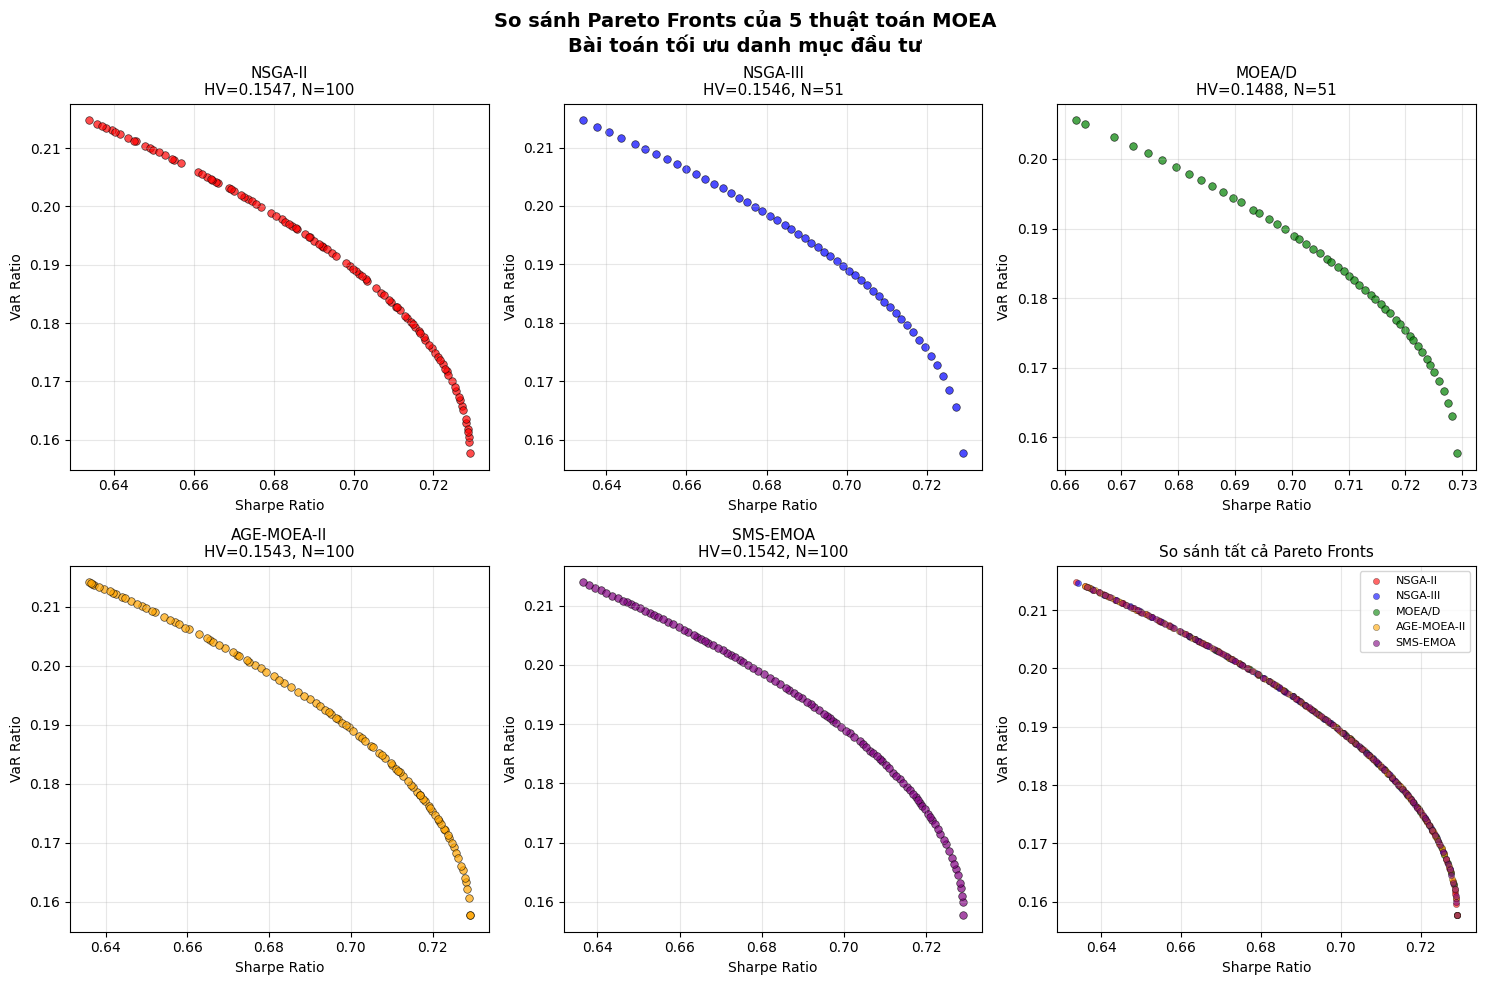

💾 Đã lưu hình: convergence.png


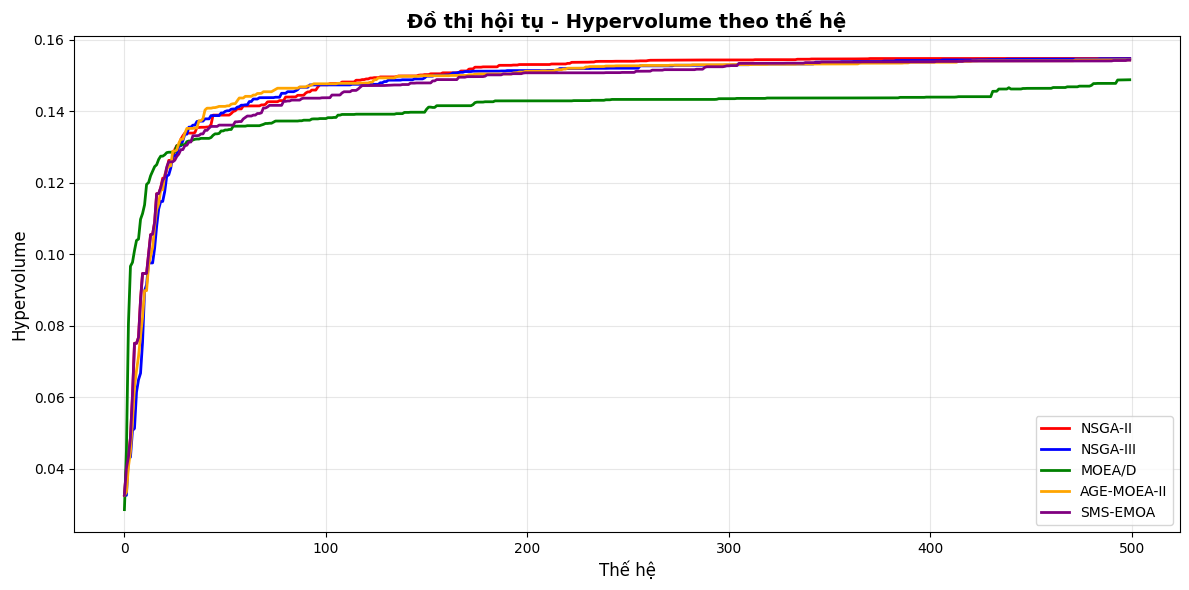

💾 Đã lưu hình: time_comparison.png


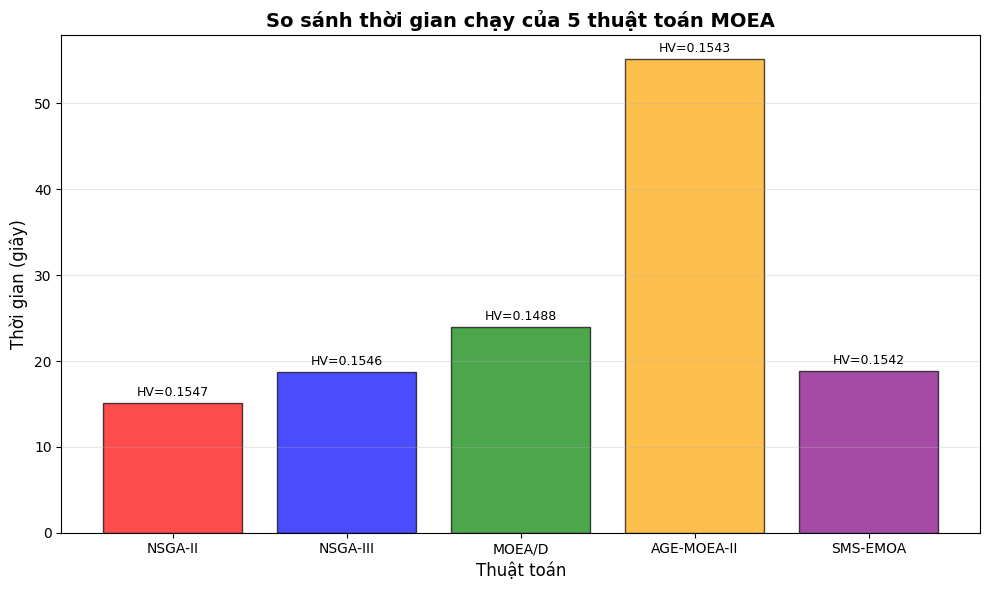


✅ HOÀN THÀNH!


In [ ]:
# ============================================================================
# HÀM MỤC TIÊU CHO DANH MỤC (GAUSSIAN FUZZY NUMBERS)
# ============================================================================
class PortfolioObjectivesGaussian:
    """
    Hàm mục tiêu cho danh mục với số mờ Gaussian (center, sigma)
    """

    def __init__(self, GFPS):
        self.GFPS = GFPS   # Gaussian Fuzzy Portfolio Set (n_assets x 2)

    def portfolio_fuzzy(self, weights):
        """
        Tính số mờ Gaussian của danh mục:
        Kết quả: [center_port, sigma_port]
        """
        return (weights.reshape(-1, 1).T @ self.GFPS).reshape(-1)

    def sharpe_ratio(self, weights):
        """
        Sharpe Ratio cho Gaussian fuzzy numbers
        """
        fuzzy = self.portfolio_fuzzy(weights)
        return SR_efn(fuzzy)     # ✅ ĐÚNG HÀM GAUSSIAN

    def var_ratio(self, weights):
        """
        VaR Ratio cho Gaussian fuzzy numbers
        """
        fuzzy = self.portfolio_fuzzy(weights)
        return VR_efn(fuzzy)     # ✅ ĐÚNG HÀM GAUSSIAN


# ============================================================================
# ĐỊNH NGHĨA BÀI TOÁN TỐI ƯU ĐA MỤC TIÊU (GAUSSIAN)
# ============================================================================
class PortfolioOptimizationProblemGaussian(Problem):
    """
    Bài toán tối ưu danh mục đầu tư đa mục tiêu với số mờ Gaussian

    Mục tiêu:
    - max Sharpe Ratio
    - max VaR Ratio
    """

    def __init__(self, GFPS):
        self.objectives = PortfolioObjectivesGaussian(GFPS)

        super().__init__(
            n_var=GFPS.shape[0],   # số cổ phiếu
            n_obj=2,
            n_constr=0,
            xl=0.0,
            xu=1.0
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # pymoo luôn MINIMIZE → lấy dấu âm
        f1 = np.apply_along_axis(
            lambda x: -self.objectives.sharpe_ratio(x), 1, X
        )
        f2 = np.apply_along_axis(
            lambda x: -self.objectives.var_ratio(x), 1, X
        )

        out["F"] = np.column_stack([f1, f2])

# ============================================================================
# REPAIR - SỬA CHỮA NGHIỆM (ĐẢM BẢO TỔNG = 1)
# ============================================================================
class PortfolioRepair(Repair):
    """
    Sửa chữa nghiệm để đảm bảo:
    - Tất cả trọng số >= 0
    - Tổng trọng số = 1
    
    Đây là cách xử lý ràng buộc thay vì dùng constraint,
    giúp tương thích với tất cả thuật toán MOEA.
    """
    
    def _do(self, problem, X, **kwargs):
        X = np.clip(X, 0, None)  # Đảm bảo không âm
        
        for i in range(X.shape[0]):
            row_sum = np.sum(X[i])
            if row_sum > 0:
                X[i] /= row_sum  # Chuẩn hóa để tổng = 1
            else:
                # Nếu tất cả = 0, phân bổ đều
                X[i] = np.ones(X.shape[1]) / X.shape[1]
        
        return X

# ============================================================================
# KHỞI TẠO CÁC THUẬT TOÁN
# ============================================================================
def create_algorithms(n_obj=2, pop_size=POP_SIZE):
    """
    Tạo dictionary chứa 5 thuật toán MOEA
    
    Parameters:
    -----------
    n_obj : int
        Số mục tiêu
    pop_size : int
        Kích thước quần thể
    
    Returns:
    --------
    dict : Dictionary {tên: thuật_toán}
    """
    
    # Reference directions cho NSGA-III và MOEA/D
    ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=50)
    
    algorithms = {
        # 1. NSGA-II: Thuật toán kinh điển, sử dụng crowding distance
        "NSGA-II": NSGA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 2. NSGA-III: Sử dụng reference points, tốt cho nhiều mục tiêu
        "NSGA-III": NSGA3(
            pop_size=pop_size,
            ref_dirs=ref_dirs,
            repair=PortfolioRepair()
        ),
        
        # 3. MOEA/D: Phân rã thành các bài toán con
        #    Lưu ý: Không hỗ trợ constraints, nên dùng Repair
        "MOEA/D": MOEAD(
            ref_dirs=ref_dirs,
            n_neighbors=20,
            prob_neighbor_mating=0.9,
            repair=PortfolioRepair()
        ),
        
        # 4. AGE-MOEA-II: Ước lượng hình học thích nghi
        "AGE-MOEA-II": AGEMOEA2(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
        
        # 5. SMS-EMOA: Sử dụng hypervolume làm tiêu chí chọn lọc
        "SMS-EMOA": SMSEMOA(
            pop_size=pop_size,
            repair=PortfolioRepair()
        ),
    }
    
    return algorithms

# ============================================================================
# CHẠY VÀ SO SÁNH CÁC THUẬT TOÁN
# ============================================================================
def run_algorithm(algorithm, problem, n_gen, seed, verbose=False):
    """
    Chạy một thuật toán và trả về kết quả
    
    Returns:
    --------
    dict : Kết quả gồm res, time, hypervolume
    """
    start_time = time.time()
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', n_gen),
        seed=seed,
        save_history=True,
        verbose=verbose
    )
    
    elapsed_time = time.time() - start_time
    
    return {
        'result': res,
        'time': elapsed_time,
        'F': res.F,
        'X': res.X
    }

def calculate_hypervolume(F, margin=0.1):
    """
    Tính Hypervolume indicator
    
    Parameters:
    -----------
    F : array
        Ma trận các giá trị mục tiêu (đã âm hóa)
    margin : float
        Khoảng cách thêm vào reference point
    
    Returns:
    --------
    float : Giá trị hypervolume
    """
    # Chuyển về giá trị dương (vì đang tối đa hóa)
    F_positive = -F
    
    # Reference point: điểm xấu nhất + margin
    ref_point = [
        np.max(F_positive[:, 0]) + margin,
        np.max(F_positive[:, 1]) + margin
    ]
    
    hv = Hypervolume(ref_point=ref_point)
    return hv.do(F_positive)

def run_comparison(FPS, n_gen=N_GEN, pop_size=POP_SIZE, seed=SEED, verbose=True):
    """
    Chạy và so sánh 5 thuật toán MOEA
    
    Returns:
    --------
    dict : Kết quả của tất cả các thuật toán
    """
    problem = PortfolioOptimizationProblem(FPS)
    algorithms = create_algorithms(n_obj=2, pop_size=pop_size)
    
    results = {}
    
    print("=" * 70)
    print("BẮT ĐẦU SO SÁNH 5 THUẬT TOÁN MOEA")
    print("=" * 70)
    print(f"📊 Số cổ phiếu: {FPS.shape[0]}")
    print(f"📊 Kích thước quần thể: {pop_size}")
    print(f"📊 Số thế hệ: {n_gen}")
    print(f"📊 Seed: {seed}")
    print("=" * 70)
    
    for name, algorithm in algorithms.items():
        print(f"\n🔄 Đang chạy {name}...")
        
        result = run_algorithm(
            algorithm, 
            problem, 
            n_gen, 
            seed, 
            verbose=False
        )
        
        # Tính hypervolume
        hv = calculate_hypervolume(result['F'])
        result['hypervolume'] = hv
        
        # Số nghiệm Pareto
        result['n_pareto'] = len(result['F'])
        
        results[name] = result
        
        print(f"   ✅ Hoàn thành trong {result['time']:.2f} giây")
        print(f"   📈 Hypervolume: {hv:.6f}")
        print(f"   🎯 Số nghiệm Pareto: {result['n_pareto']}")
    
    return results

# ============================================================================
# HIỂN THỊ KẾT QUẢ
# ============================================================================
def print_summary(results):
    """In bảng tổng hợp kết quả"""
    
    print("\n" + "=" * 70)
    print("BẢNG TỔNG HỢP KẾT QUẢ")
    print("=" * 70)
    
    # Header
    print(f"{'Thuật toán':<15} {'Hypervolume':>15} {'Số nghiệm':>12} {'Thời gian (s)':>15}")
    print("-" * 70)
    
    # Sắp xếp theo hypervolume giảm dần
    sorted_results = sorted(
        results.items(), 
        key=lambda x: x[1]['hypervolume'], 
        reverse=True
    )
    
    for i, (name, res) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else ("🥈" if i == 1 else ("🥉" if i == 2 else "  "))
        print(f"{rank} {name:<13} {res['hypervolume']:>15.6f} {res['n_pareto']:>12} {res['time']:>15.2f}")
    
    print("=" * 70)
    
    # Thuật toán tốt nhất
    best_name = sorted_results[0][0]
    print(f"\n🏆 Thuật toán tốt nhất (theo Hypervolume): {best_name}")

def plot_pareto_fronts(results, save_path=None):
    """
    Vẽ Pareto fronts của tất cả các thuật toán
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # Plot từng thuật toán riêng
    for idx, (name, res) in enumerate(results.items()):
        ax = axes[idx]
        F = -res['F']  # Chuyển về giá trị dương
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
        ax.set_xlabel('Sharpe Ratio', fontsize=10)
        ax.set_ylabel('VaR Ratio', fontsize=10)
        ax.set_title(f'{name}\nHV={res["hypervolume"]:.4f}, N={res["n_pareto"]}', fontsize=11)
        ax.grid(True, alpha=0.3)
    
    # Plot tất cả trên cùng một đồ thị
    ax = axes[5]
    for idx, (name, res) in enumerate(results.items()):
        F = -res['F']
        ax.scatter(F[:, 0], F[:, 1], c=colors[idx], alpha=0.6, s=20, label=name, edgecolors='black', linewidth=0.3)
    ax.set_xlabel('Sharpe Ratio', fontsize=10)
    ax.set_ylabel('VaR Ratio', fontsize=10)
    ax.set_title('So sánh tất cả Pareto Fronts', fontsize=11)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('So sánh Pareto Fronts của 5 thuật toán MOEA\nBài toán tối ưu danh mục đầu tư', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_convergence(results, save_path=None):
    """
    Vẽ đồ thị hội tụ (hypervolume theo thế hệ)
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for idx, (name, res) in enumerate(results.items()):
        history = res['result'].history
        
        if history is not None:
            hvs = []
            generations = []
            
            for gen, algo in enumerate(history):
                if algo.opt is not None and len(algo.opt) > 0:
                    F = algo.opt.get("F")
                    if F is not None and len(F) > 0:
                        try:
                            hv = calculate_hypervolume(F)
                            hvs.append(hv)
                            generations.append(gen)
                        except:
                            pass
            
            if hvs:
                ax.plot(generations, hvs, c=colors[idx], label=name, linewidth=2)
    
    ax.set_xlabel('Thế hệ', fontsize=12)
    ax.set_ylabel('Hypervolume', fontsize=12)
    ax.set_title('Đồ thị hội tụ - Hypervolume theo thế hệ', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def plot_time_comparison(results, save_path=None):
    """
    Vẽ biểu đồ so sánh thời gian chạy
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    names = list(results.keys())
    times = [results[name]['time'] for name in names]
    hvs = [results[name]['hypervolume'] for name in names]
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    bars = ax.bar(names, times, color=colors, alpha=0.7, edgecolor='black')
    
    # Thêm giá trị hypervolume lên mỗi cột
    for bar, hv in zip(bars, hvs):
        height = bar.get_height()
        ax.annotate(f'HV={hv:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Thuật toán', fontsize=12)
    ax.set_ylabel('Thời gian (giây)', fontsize=12)
    ax.set_title('So sánh thời gian chạy của 5 thuật toán MOEA', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu hình: {save_path}")
    
    plt.show()

def get_best_portfolio(results, tickers=None):
    """
    Lấy danh mục tốt nhất từ mỗi thuật toán
    (Nghiệm có Sharpe Ratio cao nhất)
    """
    print("\n" + "=" * 70)
    print("DANH MỤC TỐT NHẤT (SHARPE RATIO CAO NHẤT) TỪ MỖI THUẬT TOÁN")
    print("=" * 70)
    
    for name, res in results.items():
        F = -res['F']  # Chuyển về giá trị dương
        X = res['X']
        
        # Tìm nghiệm có Sharpe Ratio cao nhất
        best_idx = np.argmax(F[:, 0])
        best_weights = X[best_idx]
        best_sr = F[best_idx, 0]
        best_vr = F[best_idx, 1]
        
        print(f"\n📌 {name}:")
        print(f"   Sharpe Ratio: {best_sr:.6f}")
        print(f"   VaR Ratio: {best_vr:.6f}")
        
        # In các cổ phiếu có trọng số > 1%
        significant = np.where(best_weights > 0.01)[0]
        print(f"   Số cổ phiếu trong danh mục (>1%): {len(significant)}")
        
        if tickers is not None and len(significant) <= 10:
            print("   Phân bổ:")
            for idx in np.argsort(-best_weights[significant]):
                stock_idx = significant[idx]
                print(f"      - {tickers[stock_idx]}: {best_weights[stock_idx]*100:.2f}%")

# ============================================================================
# HÀM CHÍNH
# ============================================================================
def main():
    """Hàm chính để chạy so sánh"""
    
    print("🚀 CHƯƠNG TRÌNH SO SÁNH 5 THUẬT TOÁN MOEA")
    print("   Bài toán: Tối ưu danh mục đầu tư đa mục tiêu")
    print("   Mục tiêu: Tối đa hóa Sharpe Ratio và VaR Ratio")
    print()
    
    # Đọc dữ liệu
    TFPS, tickers = load_data(FILE_PATH)
    
    # Chạy so sánh
    results = run_comparison(
        TFPS, 
        n_gen=N_GEN, 
        pop_size=POP_SIZE, 
        seed=SEED
    )
    
    # In tổng hợp
    print_summary(results)
    
    # Danh mục tốt nhất
    get_best_portfolio(results, tickers)
    
    # Vẽ đồ thị
    print("\n📊 Đang vẽ đồ thị...")
    plot_pareto_fronts(results, save_path='pareto_fronts.png')
    plot_convergence(results, save_path='convergence.png')
    plot_time_comparison(results, save_path='time_comparison.png')
    
    print("\n✅ HOÀN THÀNH!")
    
    return results

# ============================================================================
# CHẠY CHƯƠNG TRÌNH
# ============================================================================
if __name__ == "__main__":
    results = main()
